# Unsteady Heat Conduction Equation

$$\frac{\partial T(x,t)}{\partial t} = \alpha \frac{\partial^2 T(x,t)}{\partial x^2}$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import fipy as fp

In [2]:
# Problem parameters
L = 1.0  # Length of the domain
alpha = 1.0  # Thermal diffusivity

# Discretization parameters
Nx = 100  # Number of spatial grid points
Nt = 100  # Number of time steps
dx = L / (Nx - 1)
max_time = 0.2  # Maximum time
dt = max_time / (Nt - 1)

# Initial condition
def T_initial(x):
    return np.sin(np.pi * x) + 0.5 * np.sin(3 * np.pi * x) + 0.25 * np.sin(5 * np.pi * x)

# Boundary conditions (Dirichlet)
T_left = 0.0
T_right = 0.0

In [3]:
# Generate a grid of points in the x-t domain
x_test = np.linspace(0, 1, Nx)
t_test = np.linspace(0, max_time, Nt)
x_grid, t_grid = np.meshgrid(x_test, t_test)

In [4]:
def plot_initial_temperature():
    # Evaluate the initial condition at the grid points
    T_values = T_initial(x_test)

    # Plot the initial temperature distribution
    plt.figure()
    plt.plot(x_test, T_values, label="Initial Temperature")
    plt.xlabel("x")
    plt.ylabel("Temperature")
    plt.title("Initial Temperature Distribution (t=0)")
    plt.legend()
    plt.show()

## Crank-Nicolson (Finite Difference Method)

In [5]:
def crank_nicolson():
    # Initialize the temperature matrix
    T_matrix = np.zeros((Nx, Nt))

    # Set the initial condition
    T_matrix[:, 0] = T_initial(np.linspace(0, L, Nx))

    # Set up the tridiagonal matrix for the Crank-Nicolson method
    A = np.eye(Nx - 2) * (2 + 2 * alpha * dt / dx**2) + np.eye(Nx - 2, k=1) * (-alpha * dt / dx**2) + np.eye(Nx - 2, k=-1) * (-alpha * dt / dx**2)
    B = np.eye(Nx - 2) * (2 - 2 * alpha * dt / dx**2) + np.eye(Nx - 2, k=1) * (alpha * dt / dx**2) + np.eye(Nx - 2, k=-1) * (alpha * dt / dx**2)

    # Time-stepping loop
    for n in range(1, Nt):
        # Set up the right-hand side vector
        rhs = np.dot(B, T_matrix[1:-1, n - 1])
        rhs[0] += alpha * dt / dx**2 * T_left
        rhs[-1] += alpha * dt / dx**2 * T_right

        # Solve the linear system
        T_matrix[1:-1, n] = np.linalg.solve(A, rhs)

        # Enforce boundary conditions
        T_matrix[0, n] = T_left
        T_matrix[-1, n] = T_right

    plt.figure()
    plt.contourf(np.linspace(0, L, Nx), np.linspace(0, max_time, Nt), T_matrix.T, cmap="jet")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("Temperature Distribution (Crank-Nicolson)")
    plt.colorbar(label="Temperature")
    plt.show()

## Fipy (Finite Volume PDE Solver)

In [6]:
def fipy_demo():
    # Problem parameters
    L = 1.0  # Length of the domain
    alpha = 1.0  # Thermal diffusivity

    # Create the mesh
    mesh = fp.Grid1D(nx=Nx, dx=L/Nx)

    # Define the temperature variable
    T = fp.CellVariable(name="temperature", mesh=mesh, value=0.)

    T.setValue(T_initial(T.mesh.x.value))

    # Set boundary conditions
    T.constrain(T_left, where=mesh.facesLeft)
    T.constrain(T_right, where=mesh.facesRight)

    # Define the transient diffusion equation
    eq = fp.TransientTerm() == fp.DiffusionTerm(coeff=alpha)

    # Initialize temperature history array
    T_history = np.zeros((Nt, Nx))

    # Time-stepping
    t = 0
    for step in range(Nt):
        t += dt
        eq.solve(var=T, dt=dt)
        T_history[step, :] = T.value

    # Create contour plot
    plt.contourf(x_grid, t_grid, T_history, cmap="jet")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.colorbar(label="Temperature")
    plt.title("Temperature Distribution (Fipy)")
    plt.show()

    return T_history

## PINN

In [7]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        in_units = input_dim
        for units in hidden_units:
            self.layers.append(nn.Linear(in_units, units))
            in_units = units
        self.layers.append(nn.Linear(in_units, output_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x

    def loss(self, x_f, t_f, alpha, T_left, T_right, T_initial):
        T = self(torch.cat([x_f, t_f], dim=1))

        T_x = torch.autograd.grad(T, x_f, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True, only_inputs=True)[0]
        T_xx = torch.autograd.grad(T_x, x_f, grad_outputs=torch.ones_like(T_x), create_graph=True, retain_graph=True, only_inputs=True)[0]
        T_t = torch.autograd.grad(T, t_f, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True, only_inputs=True)[0]

        f = T_t - alpha * T_xx # physics residual

        # Initial condition loss
        T_initial_pred = self(torch.cat([x_f, torch.zeros_like(t_f)], dim=1))
        T_initial_true = T_initial(x_f.detach().numpy())  # Detach x before converting to a numpy array
        T_initial_true = torch.tensor(T_initial_true, dtype=torch.float32)  # Convert back to a tensor
        ic_loss = torch.mean(torch.square(T_initial_pred - T_initial_true))

        # Boundary conditions loss
        T_left_pred = self(torch.cat([torch.zeros_like(x_f), t_f], dim=1))
        T_right_pred = self(torch.cat([torch.ones_like(x_f), t_f], dim=1))
        bc_loss = torch.mean(torch.square(T_left_pred - T_left)) + torch.mean(torch.square(T_right_pred - T_right))

        # Combine PDE residual, initial condition, and boundary condition losses
        total_loss = torch.mean(torch.square(f)) + ic_loss + bc_loss

        return total_loss

def pinn_demo(epochs=10000, learning_rate=1e-3, existing_pinn=None):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = "cpu"
  
    if not existing_pinn:
        input_dim = 2
        output_dim = 1
        hidden_units = [64, 64, 64, 64]
        pinn = PINN(input_dim, output_dim, hidden_units).to(device)
    else:
        pinn = existing_pinn

    alpha = 1.0
    Nf = 100 # number of collocation points - batch size
    optimizer = torch.optim.Adam(pinn.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        x_f = torch.tensor(np.random.uniform(0, 1, size=(Nf, 1)), dtype=torch.float32, device=device, requires_grad=True) # collocation points
        t_f = torch.tensor(np.random.uniform(0, 1, size=(Nf, 1)), dtype=torch.float32, device=device, requires_grad=True) # collocation points
        
        optimizer.zero_grad()
        loss = pinn.loss(x_f, t_f, alpha, T_left, T_right, T_initial)
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

    # Evaluate the model at the grid points
    x_test_tensor = torch.tensor(x_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
    t_test_tensor = torch.tensor(t_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
    T_test = pinn(torch.cat([x_test_tensor, t_test_tensor], dim=1))
    T_test = T_test.detach().cpu().numpy().reshape(Nt, Nx) # maybe reversed

    # Create a contour plot of the temperature distribution
    plt.figure()
    plt.contourf(x_test, t_test, T_test, cmap="jet")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("Temperature Distribution (PINN)")
    plt.colorbar(label="Temperature")
    plt.show()

    return T_test, pinn

In [8]:
def analytical_solution(alpha):
    term1 = np.sin(np.pi * x_grid) * np.exp(-(np.pi * alpha)**2 * t_grid)
    term2 = 0.5 * np.sin(3 * np.pi * x_grid) * np.exp(-9 * alpha * np.pi**2 * t_grid)
    term3 = 0.25 * np.sin(5 * np.pi * x_grid) * np.exp(-25 * alpha * np.pi**2 * t_grid)

    T = term1 + term2 + term3
    return T

def compute_analytical_solution():
    T_analytical = analytical_solution(alpha)

    plt.figure()
    plt.contourf(x_test, t_test, T_analytical, cmap="jet")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("Temperature Distribution (Analytical)")
    plt.colorbar(label="Temperature")
    plt.show()

    return T_analytical

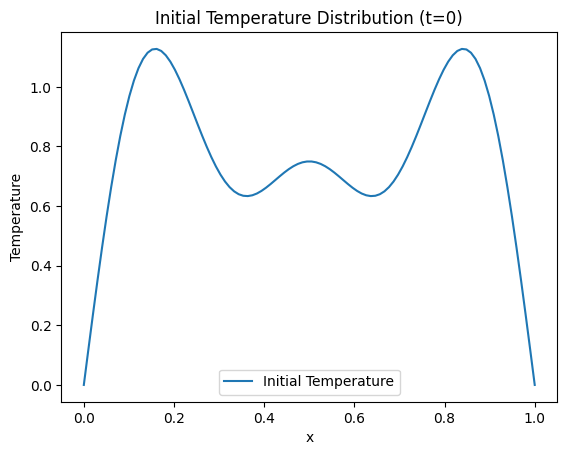

In [9]:
plot_initial_temperature()

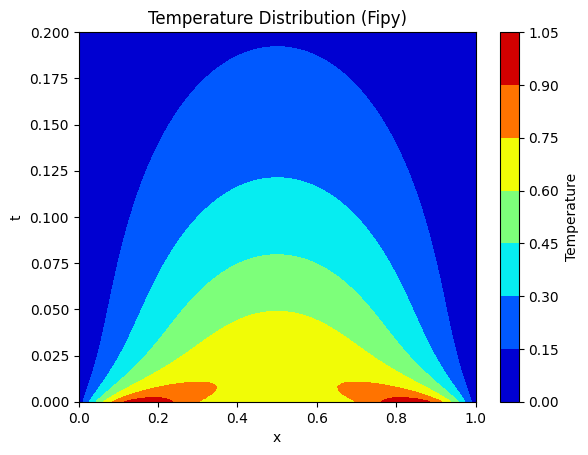

In [10]:
fipy_solution = fipy_demo()

Epoch: 0, Loss: 0.8144689798355103
Epoch: 1000, Loss: 0.07789003849029541
Epoch: 2000, Loss: 0.07820943742990494
Epoch: 3000, Loss: 0.06129945442080498
Epoch: 4000, Loss: 0.05327354371547699
Epoch: 5000, Loss: 0.0634976327419281
Epoch: 6000, Loss: 0.060583487153053284
Epoch: 7000, Loss: 0.05502263456583023
Epoch: 8000, Loss: 0.04193922504782677
Epoch: 9000, Loss: 0.05862181633710861


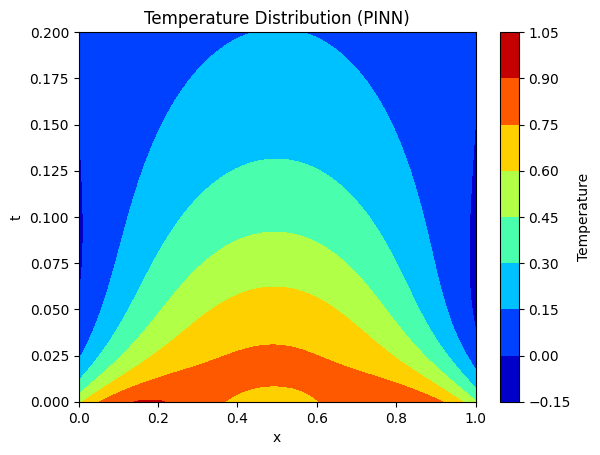

In [11]:
pinn_solution, pinn = pinn_demo(epochs=10000, learning_rate=1e-3)

Epoch: 0, Loss: 0.03256005793809891
Epoch: 1000, Loss: 0.034002941101789474
Epoch: 2000, Loss: 0.021660659462213516
Epoch: 3000, Loss: 0.02701159566640854
Epoch: 4000, Loss: 0.021187396720051765
Epoch: 5000, Loss: 0.02345670945942402
Epoch: 6000, Loss: 0.026063954457640648
Epoch: 7000, Loss: 0.024149321019649506
Epoch: 8000, Loss: 0.019159559160470963
Epoch: 9000, Loss: 0.016995718702673912


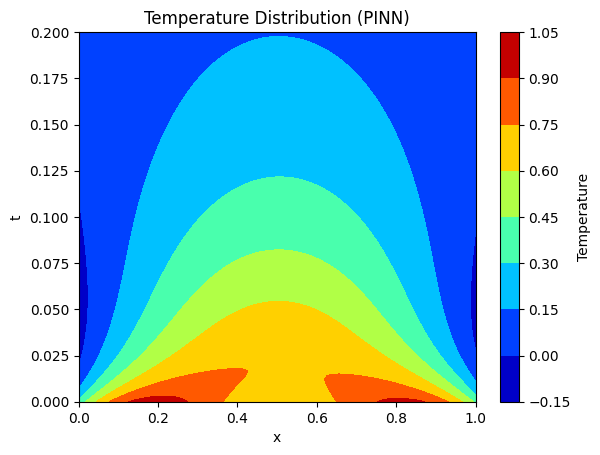

In [12]:
pinn_solution, pinn = pinn_demo(epochs=10000, learning_rate=1e-4, existing_pinn=pinn)

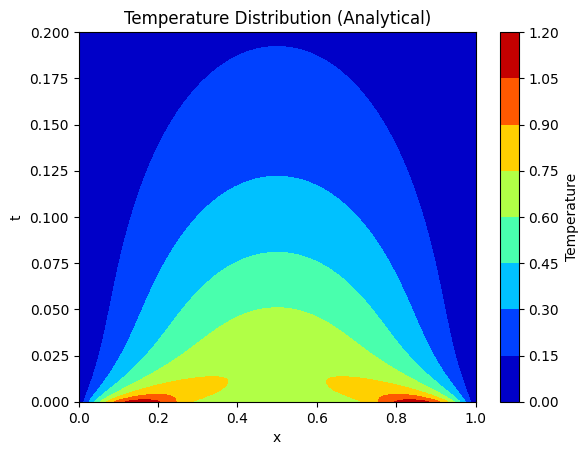

In [13]:
solution = compute_analytical_solution()

In [14]:
mse_fipy = np.mean((fipy_solution - solution)**2)
mse_pinn = np.mean((pinn_solution - solution)**2)
print(f"MSE FiPy: {mse_fipy}")
print(f"MSE PINN: {mse_pinn}")

MSE FiPy: 0.00011951309607822378
MSE PINN: 0.0007383082786901886
